In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/control-for-accelerators-in-hep/notebooks
!ls

/content/drive/My Drive/Colab Notebooks/control-for-accelerators-in-hep/notebooks
causality.ipynb		      HEP-NoisyStackedLSTM-Model_v1.ipynb
current_regulator_rule.ipynb  PlotRewardStructure.ipynb
DataAnalysis.ipynb	      surrogate_studies-newdata.ipynb


focus on top correlations to B:IMINER and B:VIMIN for now?

B:VIMIN--> B:IMINER, B:VIMAX, Std B:GMPS4V, B:LINFRQ, B:VIPHAS

B:IMINER--> B:VIMIN, B:VIMAX, B:VIPHAS, Std I:IB, I:MXIB

In [ ]:
## READ DATA ##
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

def get_data(min,max):
    ##
    df = (pd.read_csv('../data/MLParamData_1583906408.4261804_From_MLrn_2020-03-10+00_00_00_to_2020-03-11+00_00_00.h5_processed.csv.gz')[min:max])
    # df['B:GMPS4V_STD'] = df['B:GMPS4V'].rolling(window=15).std()
    # df['I:IB_STD'] = df['I:IB'].rolling(window=15).std()
    #df = df.dropna()
    print(df.shape)
    return df

df = get_data(0,-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(1309091, 15)


In [ ]:
df.loc[1309000:df.shape[0]]

,time,B:ACMNPG,B:GMPS4V,B:IMINER,B:LINFRQ,B:VIMAX,B:VIMIN,B:VINHBT,B:VIPHAS,B_ACMNPG,B_VIMIN,B_VINHBT,I:IB,I:MDAT40,I:MXIB
1309000,2020-03-11 04:59:54.048,10.000006,107.209482,0.224688,-5.070782,966.037720,103.397049,1.0,1.804843,10.000006,103.41964,1.0,4070.9375,2907.409656,2896.374512
1309001,2020-03-11 04:59:54.114,10.000006,107.859483,0.229687,-5.034406,966.050781,103.396393,1.0,1.805050,10.000006,103.41964,1.0,2978.4375,1855.773918,1845.132446
1309002,2020-03-11 04:59:54.180,10.000006,97.459472,0.139687,-5.061688,966.083496,103.405487,1.0,1.805226,10.000006,103.41964,1.0,1919.6875,833.740231,823.291016
1309003,2020-03-11 04:59:54.246,10.000006,109.809485,0.099687,-4.966199,966.076965,103.409859,1.0,1.805393,10.000006,103.41964,1.0,900.9375,369.567870,370.416260
1309004,2020-03-11 04:59:54.312,10.000006,108.509484,0.019688,-4.993481,966.106384,103.417992,1.0,1.805651,10.000006,103.41964,1.0,368.4375,502.166746,502.444458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309086,2020-03-11 04:59:59.724,NaN,103.959479,0.094687,-4.538770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2977.1875,1855.773918,1845.101929
1309087,2020-03-11 04:59:59.790,10.000006,92.259467,0.014687,-4.634259,966.067139,103.417885,1.0,1.807119,10.000006,103.41964,1.0,1924.6875,833.740231,823.275757
1309088,2020-03-11 04:59:59.856,10.000006,105.259480,-0.020313,-4.543317,966.090027,103.421623,1.0,1.806906,10.000006,103.41964,1.0,894.6875,369.415282,370.404053
1309089,2020-03-11 04:59:59.922,10.000006,105.259480,-0.065312,-4.538770,966.093323,103.426155,1.0,1.807058,10.000006,103.41964,1.0,367.1875,502.166746,502.441406


In [ ]:
df.isnull().sum()

time            0
B:ACMNPG    15005
B:GMPS4V    24114
B:IMINER    24114
B:LINFRQ    14677
B:VIMAX     15005
B:VIMIN     15005
B:VINHBT    15005
B:VIPHAS    15005
B_ACMNPG    15005
B_VIMIN     15005
B_VINHBT    15005
I:IB        20229
I:MDAT40    14703
I:MXIB      14703
dtype: int64

In [ ]:
df['B_VIMIN'].mean(skipna = True)

103.41473924949591

In [ ]:
df = df.dropna()
variables = df.columns.to_list()
variables.remove('time')

In [ ]:
#create a new dataframe with just the trend
trends = pd.DataFrame()

for i in variables:
  result_add = seasonal_decompose(df[str(i)], model='additive',  freq=25)
  trends[str(i)] = result_add.trend.dropna()

In [ ]:
trends = trends.reset_index(drop = True)
trends.head()

#use trends for now 
data = trends

# STOP FOR HEATMAP

In [ ]:
#test for normality

def qq_histo(variable, df):
  plt.figure(figsize = (10, 5))
  plt.subplot(1,2,1)
  df[str(variable)].hist(bins = 100)
  plt.xlim(df[str(variable)].min()-1, df[str(variable)].max()+1)
  plt.semilogy()

  plt.title(str(variable))
  plt.subplot(1,2,2)
  stats.probplot(df[str(variable)], plot = plt)
  df[str(variable)].describe().T

Statistics for B:ACMNPG = 594123.362, p-value = 0.0
Data looks non-Gaussian --> reject null hypothesis
Statistics for B:GMPS4V = 172598.155, p-value = 0.0
Data looks non-Gaussian --> reject null hypothesis
Statistics for B:IMINER = 139629.588, p-value = 0.0
Data looks non-Gaussian --> reject null hypothesis
Statistics for B:LINFRQ = 31143.016, p-value = 0.0
Data looks non-Gaussian --> reject null hypothesis
Statistics for B:VIMAX = 183130.065, p-value = 0.0
Data looks non-Gaussian --> reject null hypothesis
Statistics for B:VIMIN = 314082.182, p-value = 0.0
Data looks non-Gaussian --> reject null hypothesis
Statistics for B:VINHBT = 751009.461, p-value = 0.0
Data looks non-Gaussian --> reject null hypothesis
Statistics for B:VIPHAS = 2114.819, p-value = 0.0
Data looks non-Gaussian --> reject null hypothesis
Statistics for B_ACMNPG = 593772.036, p-value = 0.0
Data looks non-Gaussian --> reject null hypothesis
Statistics for B_VIMIN = 16503.217, p-value = 0.0
Data looks non-Gaussian --> 

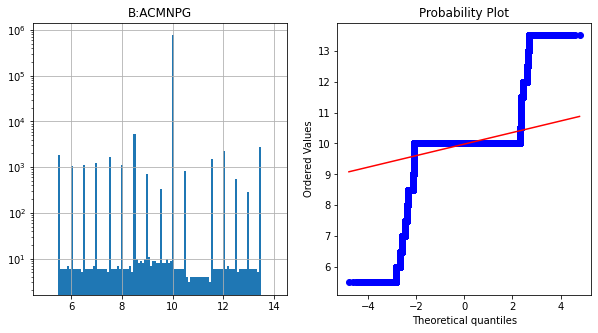

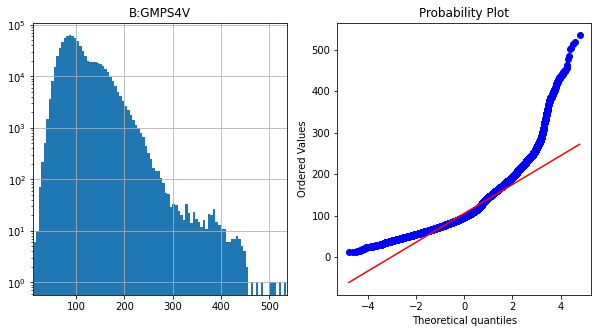

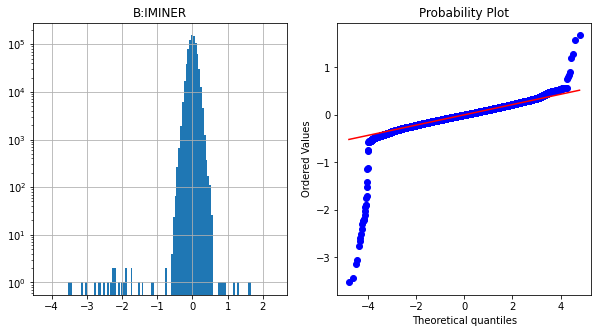

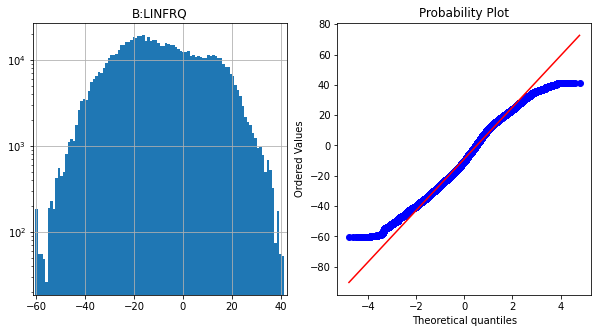

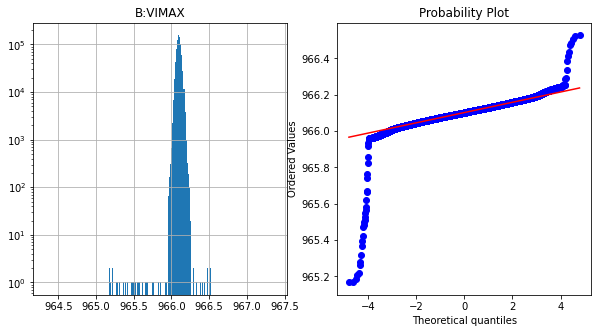

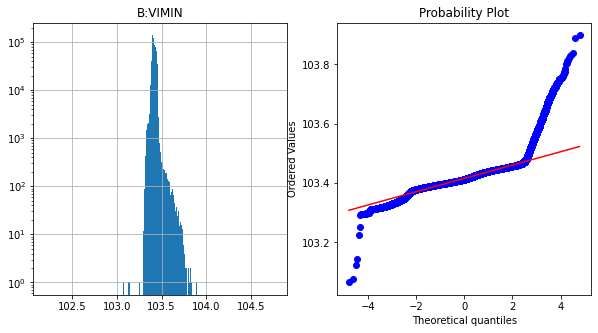

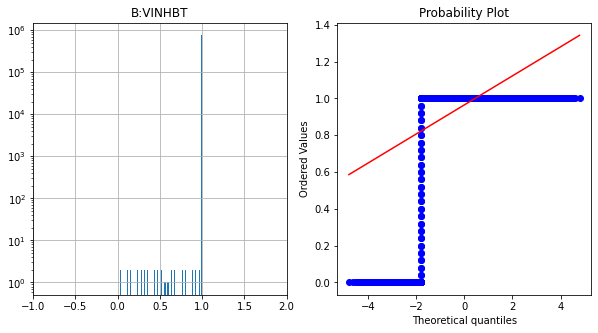

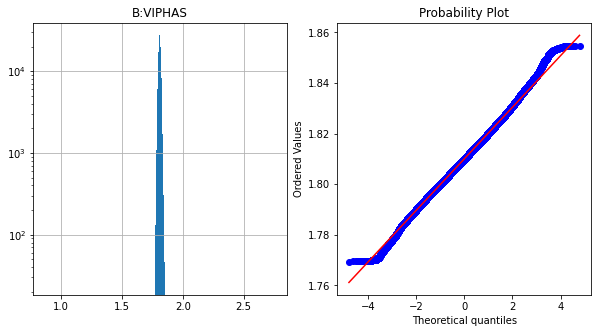

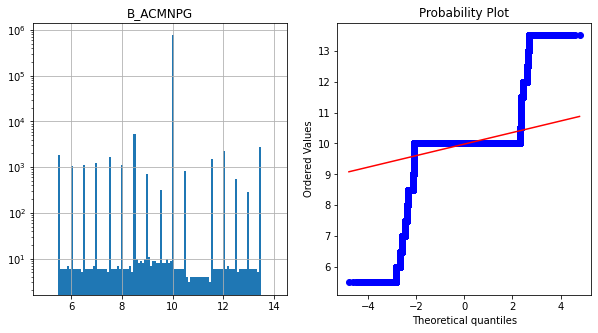

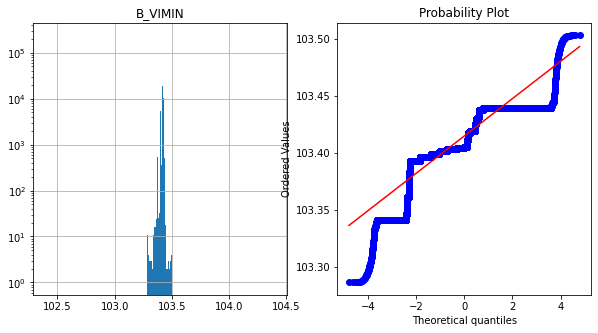

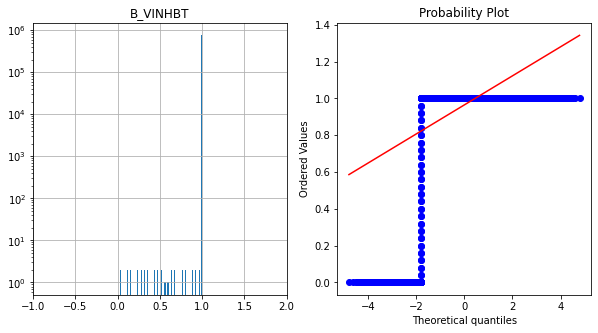

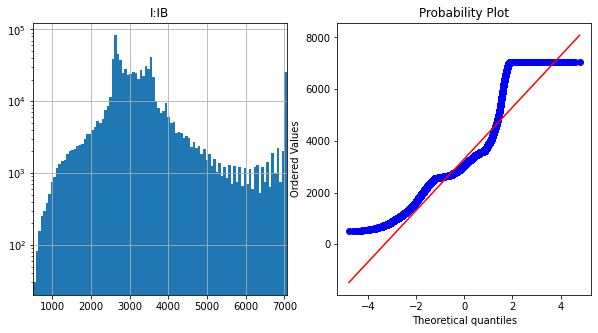

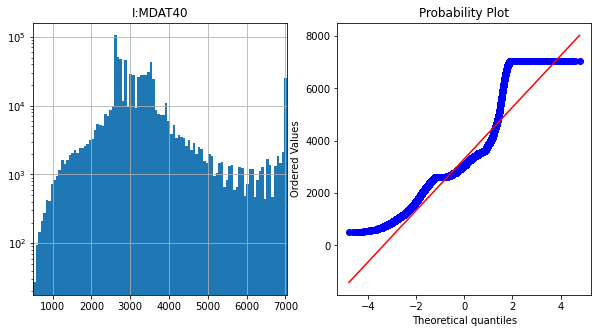

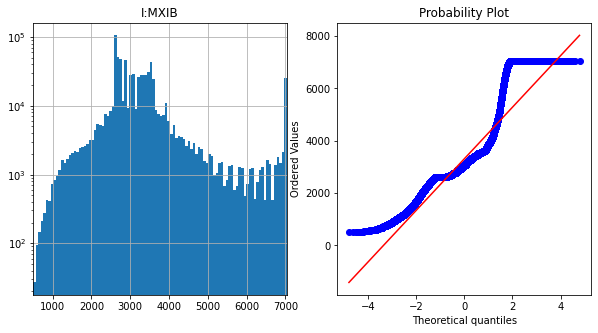

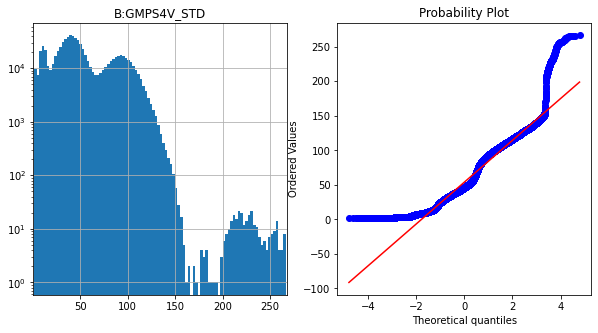

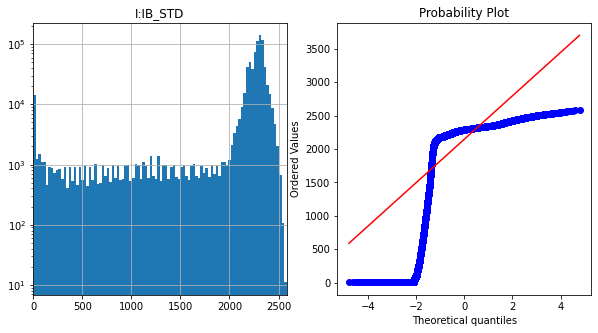

In [ ]:
for i in variables: 
  z_score, p_value = stats.normaltest(data[i])
  print(f'Statistics for {str(i)} = {z_score:.3f}, p-value = {p_value}')
  
  alpha = 0.05 #hypothesis test at 95% confidence
  if p_value > alpha:
    print('Data looks Gaussian --> accept null hypothesis')
    qq_histo(str(i))
  else:
    print('Data looks non-Gaussian --> reject null hypothesis')
    qq_histo(str(i), trends)
    #qq_histo(str(i), df)

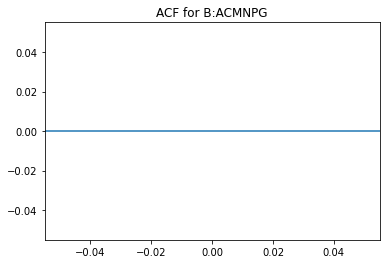

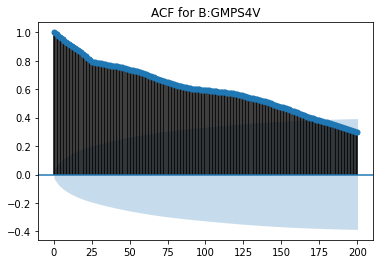

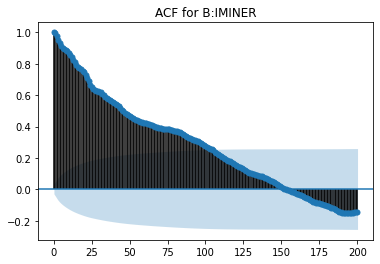

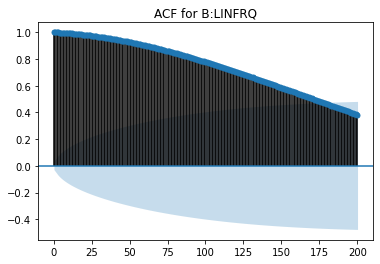

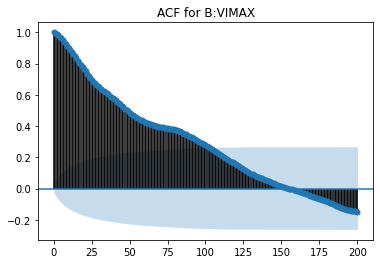

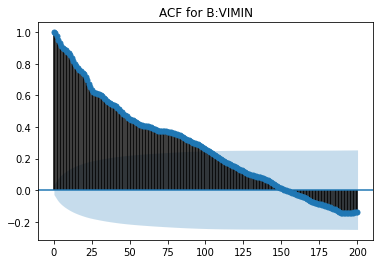

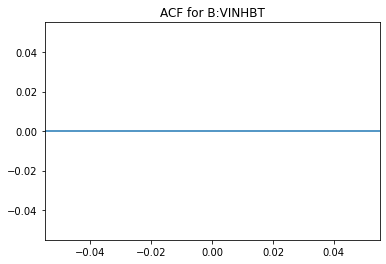

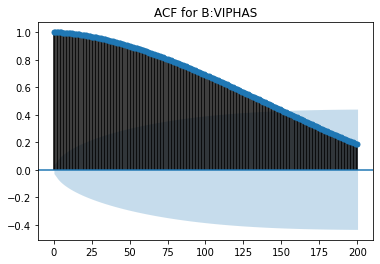

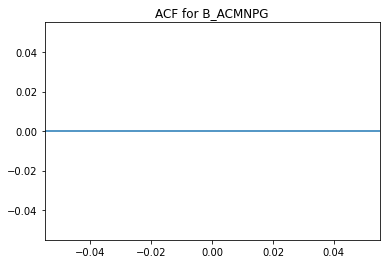

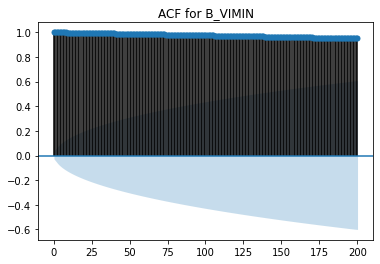

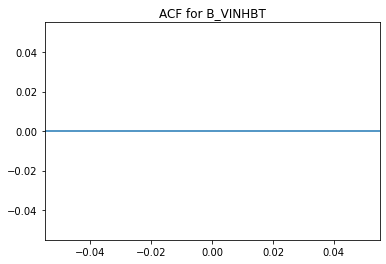

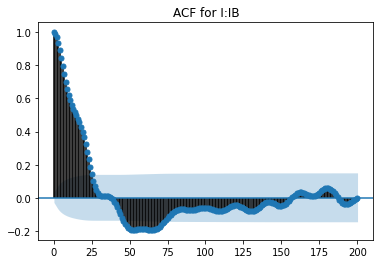

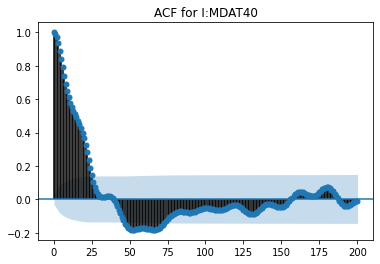

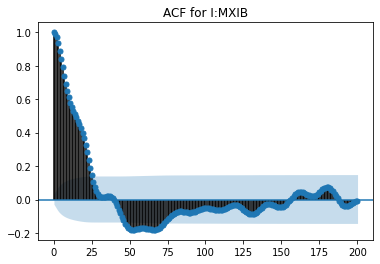

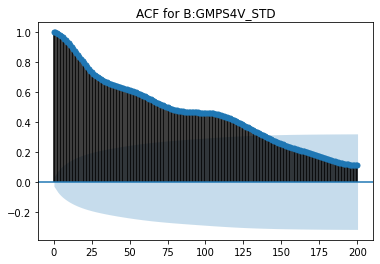

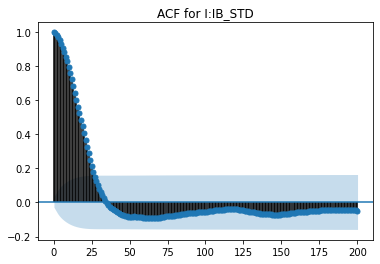

In [ ]:
#first autocorrelation

for i in variables:
  sm.graphics.tsa.plot_acf(data[i].loc[0:4000], lags = 200, alpha = .05)
  plt.title(f'ACF for {str(i)}')
  plt.show()

In [ ]:
look_forward = 400 #this part is pretty irrelevant right now
train, test = data[0:-look_forward], data[-look_forward:]

train.shape, test.shape

# time = train.time
# train.drop(['time'], axis = 1, inplace = True)

((786528, 16), (400, 16))

In [ ]:
#attempt standardization/remove temporal dependene
#have to do first difference and second difference

transform = train.diff().dropna()
transform.describe()

,B:ACMNPG,B:GMPS4V,B:IMINER,B:LINFRQ,B:VIMAX,B:VIMIN,B:VINHBT,B:VIPHAS,B_ACMNPG,B_VIMIN,B_VINHBT,I:IB,I:MDAT40,I:MXIB,B:GMPS4V_STD,I:IB_STD
count,786527.00000,786527.000000,7.865270e+05,786527.000000,7.865270e+05,7.865270e+05,7.865270e+05,7.865270e+05,786527.00000,7.865270e+05,7.865270e+05,786527.000000,786527.000000,786527.000000,786527.000000,786527.000000
mean,0.00000,-0.000049,3.692181e-07,-0.000018,6.801869e-08,-2.787034e-09,7.057755e-23,2.571970e-08,0.00000,3.366907e-08,7.057755e-23,0.000531,0.000484,0.000484,-0.000005,-0.000023
std,0.00093,3.613761,1.253384e-02,0.076092,2.023091e-03,1.673766e-03,3.189249e-04,1.177583e-04,0.00093,4.449726e-05,3.189249e-04,122.479214,120.253003,120.253116,0.940981,34.774347
min,-0.06000,-27.768028,-3.914000e-01,-1.123320,-1.691479e-01,-1.076740e-01,-4.000000e-02,-1.514544e-03,-0.06000,-2.918701e-03,-4.000000e-02,-268.350000,-266.558837,-266.558096,-8.088768,-118.944300
25%,0.00000,-1.638002,-7.200000e-03,-0.041288,-1.306152e-03,-7.388306e-04,0.000000e+00,-6.874080e-05,0.00000,0.000000e+00,0.000000e+00,-85.950000,-74.707031,-74.708867,-0.472414,-16.105862
50%,0.00000,0.000000,-2.000000e-04,-0.000546,0.000000e+00,1.220720e-05,0.000000e+00,-7.344000e-07,0.00000,0.000000e+00,0.000000e+00,0.050000,0.000000,0.000366,-0.002949,0.013461
75%,0.00000,1.638002,7.000000e-03,0.040378,1.306152e-03,7.427980e-04,0.000000e+00,6.854060e-05,0.00000,0.000000e+00,0.000000e+00,86.000000,87.591552,87.588384,0.469367,16.365927
max,0.06000,32.526033,3.960000e-01,1.477268,1.734668e-01,1.069080e-01,4.000000e-02,1.323547e-03,0.06000,2.239075e-03,4.000000e-02,267.950000,266.558837,266.558101,6.117969,122.595550


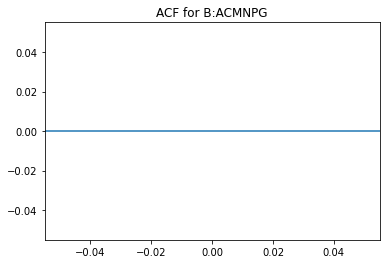

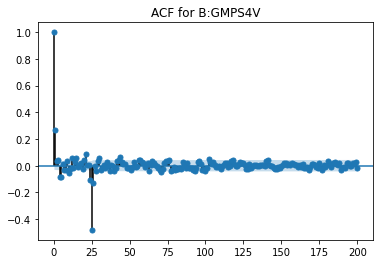

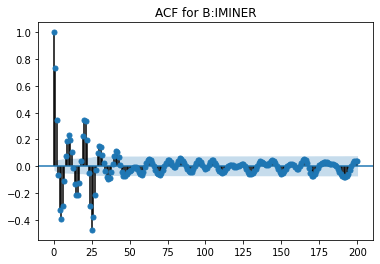

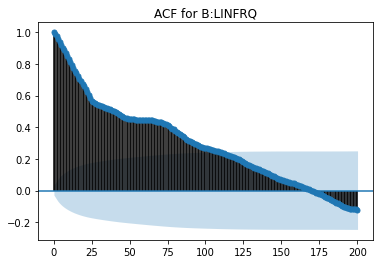

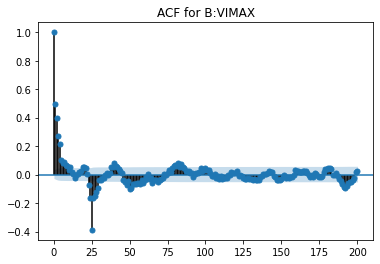

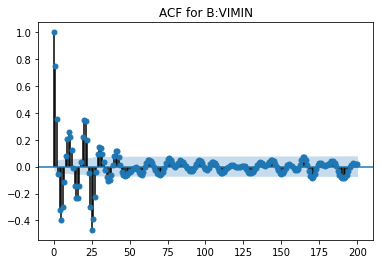

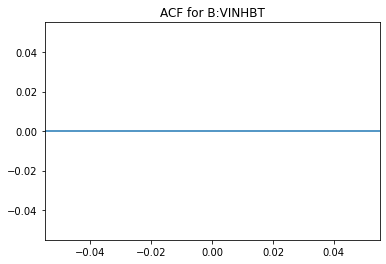

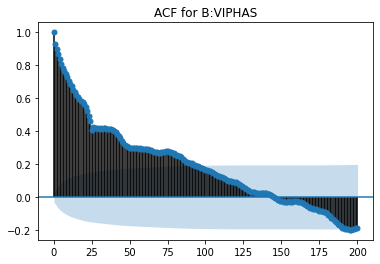

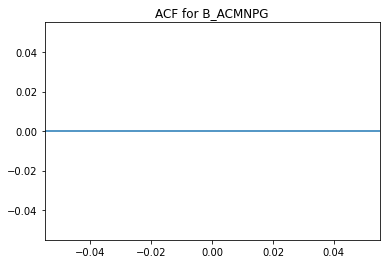

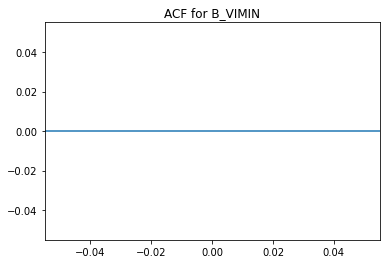

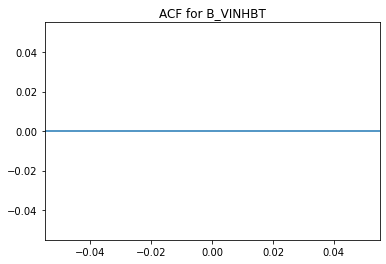

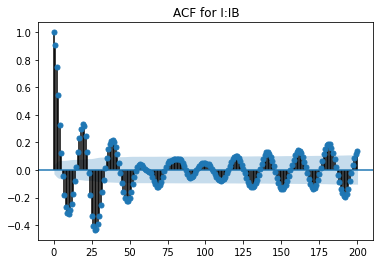

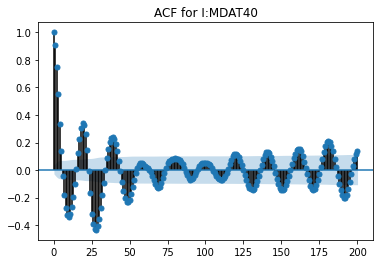

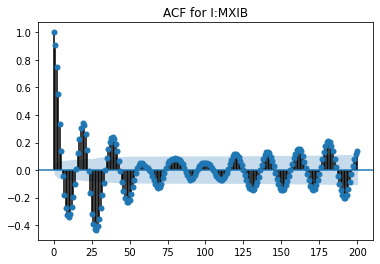

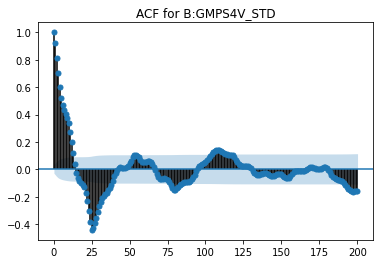

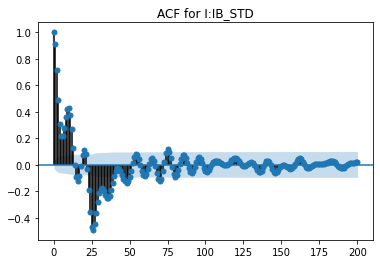

In [ ]:
#check autocorrelation
for i in variables:
  sm.graphics.tsa.plot_acf(transform[i].loc[0:4000], lags = 200, alpha = .05)
  plt.title(f'ACF for {str(i)}')
  plt.show()

In [ ]:
transform.shape

(786527, 16)

In [ ]:
#Check for stationarity using ADF (null is non-stationarity)
#and cross check with KPSS test (null is stationarity)

def ADF(variable, **kw):

  time_series = transform[str(variable)].loc[0:10000]
  result = sm.tsa.stattools.adfuller(time_series.values, **kw)
  
  # print('ADF Statistic: %f' % result[0])
  # print('p-value: %f' % result[1])
  # print('Critical Values:')
  
  # for key, value in result[4].items():
  #   print('\t%s: %.3f' % (key, value))
  
  print(f'ADF Result: The series is {"stationary" if result[1] < 0.05 else "not stationary"}')
  return("stationary" if result[1] < 0.05 else "not stationary")

def kpss_test(series, **kw):    
  statistic, p_value, n_lags, critical_values = kpss(transform[str(series)].loc[0:10000], **kw)

  # print(f'KPSS Statistic: {statistic}')
  # print(f'p-value: {p_value}')
  # print(f'num lags: {n_lags}')
  # print('Critial Values:')

  # for key, value in critical_values.items():
  #     print(f'   {key} : {value}')

  print(f'KPSS Result: The series is {"not stationary" if p_value < 0.05 else "stationary"}')
  return("not stationary" if p_value < 0.05 else "stationary")

for i in variables: #check for constant, time trend, and time trend squared
  print(f'Checking for stationarity: {str(i)} Time Series')
  result1 = ADF(i, regression='ctt')
  result2 = kpss_test(i, regression='ct')

  if result1 != result2:
    print("Discrepancy for "+str(i))
  
  print()

Checking for stationarity: B:ACMNPG Time Series
ADF Result: The series is not stationary
KPSS Result: The series is stationary
Discrepancy for B:ACMNPG

Checking for stationarity: B:GMPS4V Time Series
ADF Result: The series is stationary
KPSS Result: The series is stationary

Checking for stationarity: B:IMINER Time Series
ADF Result: The series is stationary
KPSS Result: The series is stationary

Checking for stationarity: B:LINFRQ Time Series
ADF Result: The series is stationary
KPSS Result: The series is stationary

Checking for stationarity: B:VIMAX Time Series
ADF Result: The series is stationary
KPSS Result: The series is stationary

Checking for stationarity: B:VIMIN Time Series
ADF Result: The series is stationary
KPSS Result: The series is stationary

Checking for stationarity: B:VINHBT Time Series
ADF Result: The series is not stationary
KPSS Result: The series is stationary
Discrepancy for B:VINHBT

Checking for stationarity: B:VIPHAS Time Series
ADF Result: The series is st

In [ ]:
for_BVIMIN = transform[['B:VIMIN', 'B:IMINER', 'B:VIMAX', 'B:GMPS4V_STD', 'B:LINFRQ', 'B:VIPHAS']]
for_BIMINER = transform[['B:IMINER', 'B:VIMIN', 'B:VIMAX', 'B:VIPHAS', 'I:IB_STD', 'I:MXIB']]

#V:MIN is only nonstationary

In [ ]:
for_BVIMIN

,B:VIMIN,B:IMINER,B:VIMAX,B:GMPS4V_STD,B:LINFRQ,B:VIPHAS
1,0.001307,-0.0092,-0.003140,-0.755109,-0.159149,-0.000275
2,0.000936,-0.0072,0.000393,-0.681565,-0.159513,-0.000324
3,0.000073,-0.0002,-0.001311,-0.475722,-0.153511,-0.000311
4,0.000028,0.0070,-0.004058,-0.237663,-0.154602,-0.000285
5,0.001017,-0.0070,0.000132,-0.222261,-0.231176,-0.000400
...,...,...,...,...,...,...
786523,0.001088,-0.0108,-0.000916,-0.043991,0.020189,-0.000044
786524,0.001298,-0.0128,-0.004709,-0.030364,0.016370,-0.000053
786525,0.001545,-0.0152,-0.001831,-0.017296,0.012914,-0.000084
786526,0.000555,-0.0054,-0.002876,-0.009822,0.010731,-0.000123


In [ ]:
maxlag = 100
test = 'ssr-chi2test'

def granger_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns = variables, index = variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train[[r,c]].loc[1:2001], maxlag = maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value

  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  
  return dataset

granger_causality_matrix(for_BVIMIN, variables = for_BVIMIN.columns)

,B:VIMIN_x,B:IMINER_x,B:VIMAX_x,B:GMPS4V_STD_x,B:LINFRQ_x,B:VIPHAS_x
B:VIMIN_y,1.0,0.0,0.0000,0.0027,0.0000,0.0000
B:IMINER_y,0.0,1.0,0.0000,0.0008,0.0000,0.0000
B:VIMAX_y,0.0,0.0,1.0000,0.0019,0.0000,0.0000
B:GMPS4V_STD_y,0.0,0.0,0.0839,1.0000,0.0098,0.0089
B:LINFRQ_y,0.0,0.0,0.0000,0.0003,1.0000,0.0001
B:VIPHAS_y,0.0,0.0,0.0000,0.0000,0.0000,1.0000


In [ ]:
granger_causality_matrix(for_BIMINER, variables = for_BIMINER.columns)

,B:IMINER_x,B:VIMIN_x,B:VIMAX_x,B:VIPHAS_x,I:IB_STD_x,I:MXIB_x
B:IMINER_y,1.0,0.0,0.0,0.0000,0.0,0.0
B:VIMIN_y,0.0,1.0,0.0,0.0000,0.0,0.0
B:VIMAX_y,0.0,0.0,1.0,0.0000,0.0,0.0
B:VIPHAS_y,0.0,0.0,0.0,1.0000,0.0,0.0
I:IB_STD_y,0.0,0.0,0.0,0.0000,1.0,0.0
I:MXIB_y,0.0,0.0,0.0,0.0243,0.0,1.0


In [ ]:
grangercausalitytests(for_BVIMIN[['B:VIMIN', 'B:IMINER']].loc[0:10000], maxlag = 100, verbose=False)

In [ ]:
granger_causality_matrix(transform, variables = transform.columns)

,B:ACMNPG_x,B:GMPS4V_x,B:IMINER_x,B:LINFRQ_x,B:VIMAX_x,B:VIMIN_x,B:VINHBT_x,B:VIPHAS_x,B_ACMNPG_x,B_VIMIN_x,B_VINHBT_x,I:IB_x,I:MDAT40_x,I:MXIB_x,B:GMPS4V_STD_x,I:IB_STD_x
B:ACMNPG_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B:GMPS4V_y,1.0,1.0000,0.0,0.0000,0.0000,0.0001,1.0,0.0000,1.0,1.0,1.0,0.0,0.0,0.0,0.0371,0.0
B:IMINER_y,1.0,0.0071,1.0,0.0000,0.0000,0.0000,1.0,0.0000,1.0,1.0,1.0,0.0,0.0,0.0,0.0008,0.0
B:LINFRQ_y,1.0,0.0000,0.0,1.0000,0.0000,0.0000,1.0,0.0001,1.0,1.0,1.0,0.0,0.0,0.0,0.0003,0.0
B:VIMAX_y,1.0,0.0001,0.0,0.0000,1.0000,0.0000,1.0,0.0000,1.0,1.0,1.0,0.0,0.0,0.0,0.0019,0.0
B:VIMIN_y,1.0,0.0001,0.0,0.0000,0.0000,1.0000,1.0,0.0000,1.0,1.0,1.0,0.0,0.0,0.0,0.0027,0.0
B:VINHBT_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B:VIPHAS_y,1.0,0.0000,0.0,0.0000,0.0000,0.0000,1.0,1.0000,1.0,1.0,1.0,0.0,0.0,0.0,0.0000,0.0
B_ACMNPG_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B_VIMIN_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_result[1][0]['ssr_chi2test']

(424.78614301076334, 2.2166621524168026e-94, 1)

# RESUME

In [ ]:
new_df = data.diff().dropna()

In [ ]:
from typing import Any, Optional

def int_like(
    value: Any, name: str, optional: bool = False, strict: bool = False
) -> Optional[int]:
    """
    Convert to int or raise if not int_like
    Parameters
    ----------
    value : object
        Value to verify
    name : str
        Variable name for exceptions
    optional : bool
        Flag indicating whether None is allowed
    strict : bool
        If True, then only allow int or np.integer that are not bool. If False,
        allow types that support integer division by 1 and conversion to int.
    Returns
    -------
    converted : int
        value converted to a int
    """
    if optional and value is None:
        return None
    is_bool_timedelta = isinstance(value, (bool, np.timedelta64))

    if hasattr(value, "squeeze") and callable(value.squeeze):
        value = value.squeeze()

    if isinstance(value, (int, np.integer)) and not is_bool_timedelta:
        return int(value)
    elif not strict and not is_bool_timedelta:
        try:
            if value == (value // 1):
                return int(value)
        except Exception:
            pass
    extra_text = " or None" if optional else ""
    raise TypeError(
        "{0} must be integer_like (int or np.integer, but not bool"
        " or timedelta64){1}".format(name, extra_text)
    )

def array_like(
    obj,
    name,
    dtype=np.double,
    ndim=1,
    maxdim=None,
    shape=None,
    order=None,
    contiguous=False,
    optional=False,
):
    """
    Convert array-like to a ndarray and check conditions
    Parameters
    ----------
    obj : array_like
         An array, any object exposing the array interface, an object whose
        __array__ method returns an array, or any (nested) sequence.
    name : str
        Name of the variable to use in exceptions
    dtype : {None, numpy.dtype, str}
        Required dtype. Default is double. If None, does not change the dtype
        of obj (if present) or uses NumPy to automatically detect the dtype
    ndim : {int, None}
        Required number of dimensions of obj. If None, no check is performed.
        If the numebr of dimensions of obj is less than ndim, additional axes
        are inserted on the right. See examples.
    maxdim : {int, None}
        Maximum allowed dimension.  Use ``maxdim`` instead of ``ndim`` when
        inputs are allowed to have ndim 1, 2, ..., or maxdim.
    shape : {tuple[int], None}
        Required shape obj.  If None, no check is performed. Partially
        restricted shapes can be checked using None. See examples.
    order : {'C', 'F', None}
        Order of the array
    contiguous : bool
        Ensure that the array's data is contiguous with order ``order``
    optional : bool
        Flag indicating whether None is allowed
    Returns
    -------
    ndarray
        The converted input.
    Examples
    --------
    Convert a list or pandas series to an array
    >>> import pandas as pd
    >>> x = [0, 1, 2, 3]
    >>> a = array_like(x, 'x', ndim=1)
    >>> a.shape
    (4,)
    >>> a = array_like(pd.Series(x), 'x', ndim=1)
    >>> a.shape
    (4,)
    >>> type(a.orig)
    pandas.core.series.Series
    Squeezes singleton dimensions when required
    >>> x = np.array(x).reshape((4, 1))
    >>> a = array_like(x, 'x', ndim=1)
    >>> a.shape
    (4,)
    Right-appends when required size is larger than actual
    >>> x = [0, 1, 2, 3]
    >>> a = array_like(x, 'x', ndim=2)
    >>> a.shape
    (4, 1)
    Check only the first and last dimension of the input
    >>> x = np.arange(4*10*4).reshape((4, 10, 4))
    >>> y = array_like(x, 'x', ndim=3, shape=(4, None, 4))
    Check only the first two dimensions
    >>> z = array_like(x, 'x', ndim=3, shape=(4, 10))
    Raises ValueError if constraints are not satisfied
    >>> z = array_like(x, 'x', ndim=2)
    Traceback (most recent call last):
     ...
    ValueError: x is required to have ndim 2 but has ndim 3
    >>> z = array_like(x, 'x', shape=(10, 4, 4))
    Traceback (most recent call last):
     ...
    ValueError: x is required to have shape (10, 4, 4) but has shape (4, 10, 4)
    >>> z = array_like(x, 'x', shape=(None, 4, 4))
    Traceback (most recent call last):
     ...
    ValueError: x is required to have shape (*, 4, 4) but has shape (4, 10, 4)
    """
    if optional and obj is None:
        return None
    arr = np.asarray(obj, dtype=dtype, order=order)
    if maxdim is not None:
        if arr.ndim > maxdim:
            msg = "{0} must have ndim <= {1}".format(name, maxdim)
            raise ValueError(msg)
    elif ndim is not None:
        if arr.ndim > ndim:
            arr = _right_squeeze(arr, stop_dim=ndim)
        elif arr.ndim < ndim:
            arr = np.reshape(arr, arr.shape + (1,) * (ndim - arr.ndim))
        if arr.ndim != ndim:
            msg = "{0} is required to have ndim {1} but has ndim {2}"
            raise ValueError(msg.format(name, ndim, arr.ndim))
    if shape is not None:
        for actual, req in zip(arr.shape, shape):
            if req is not None and actual != req:
                req_shape = str(shape).replace("None, ", "*, ")
                msg = "{0} is required to have shape {1} but has shape {2}"
                raise ValueError(msg.format(name, req_shape, arr.shape))
    if contiguous:
        arr = np.ascontiguousarray(arr, dtype=dtype)
    return arr

def bool_like(value, name, optional=False, strict=False):
    """
    Convert to bool or raise if not bool_like
    Parameters
    ----------
    value : object
        Value to verify
    name : str
        Variable name for exceptions
    optional : bool
        Flag indicating whether None is allowed
    strict : bool
        If True, then only allow bool. If False, allow types that support
        casting to bool.
    Returns
    -------
    converted : bool
        value converted to a bool
    """
    if optional and value is None:
        return value
    extra_text = " or None" if optional else ""
    if strict:
        if isinstance(value, bool):
            return value
        else:
            raise TypeError("{0} must be a bool{1}".format(name, extra_text))

    if hasattr(value, "squeeze") and callable(value.squeeze):
        value = value.squeeze()
    try:
        return bool(value)
    except Exception:
        raise TypeError(
            "{0} must be a bool (or bool-compatible)"
            "{1}".format(name, extra_text)
        )

In [ ]:
#stolen from https://www.statsmodels.org/stable/_modules/statsmodels/tsa/stattools.html#grangercausalitytests

from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import lagmat, lagmat2ds
from statsmodels.tools.validation import (array_like, string_like, bool_like,
                                          int_like, dict_like, float_like)

def edited_grangercausalitytest(x, maxlag, addconst=True, verbose=True):
    """
    Four tests for granger non causality of 2 time series.

    All four tests give similar results. `params_ftest` and `ssr_ftest` are
    equivalent based on F test which is identical to lmtest:grangertest in R.

    Parameters
    ----------
    x : array_like
        The data for test whether the time series in the second column Granger
        causes the time series in the first column. Missing values are not
        supported.
    maxlag : {int, Iterable[int]}
        If an integer, computes the test for all lags up to maxlag. If an
        iterable, computes the tests only for the lags in maxlag.
    addconst : bool
        Include a constant in the model.
    verbose : bool
        Print results.

    Returns
    -------
    dict
        All test results, dictionary keys are the number of lags. For each
        lag the values are a tuple, with the first element a dictionary with
        test statistic, pvalues, degrees of freedom, the second element are
        the OLS estimation results for the restricted model, the unrestricted
        model and the restriction (contrast) matrix for the parameter f_test.

    Notes
    -----
    TODO: convert to class and attach results properly

    The Null hypothesis for grangercausalitytests is that the time series in
    the second column, x2, does NOT Granger cause the time series in the first
    column, x1. Grange causality means that past values of x2 have a
    statistically significant effect on the current value of x1, taking past
    values of x1 into account as regressors. We reject the null hypothesis
    that x2 does not Granger cause x1 if the pvalues are below a desired size
    of the test.

    The null hypothesis for all four test is that the coefficients
    corresponding to past values of the second time series are zero.

    'params_ftest', 'ssr_ftest' are based on F distribution

    'ssr_chi2test', 'lrtest' are based on chi-square distribution

    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Granger_causality

    .. [2] Greene: Econometric Analysis

    Examples
    --------
    >>> import statsmodels.api as sm
    >>> from statsmodels.tsa.stattools import grangercausalitytests
    >>> import numpy as np
    >>> data = sm.datasets.macrodata.load_pandas()
    >>> data = data.data[['realgdp', 'realcons']].pct_change().dropna()

    # All lags up to 4
    >>> gc_res = grangercausalitytests(data, 4)

    # Only lag 4
    >>> gc_res = grangercausalitytests(data, [4])
    """
    x = array_like(x, 'x', ndim=2)
    if not np.isfinite(x).all():
        raise ValueError('x contains NaN or inf values.')
    addconst = bool_like(addconst, 'addconst')
    verbose = bool_like(verbose, 'verbose')
    try:
        lags = np.array([int(lag) for lag in maxlag])
        maxlag = lags.max()
        if lags.min() <= 0 or lags.size == 0:
            raise ValueError('maxlag must be a non-empty list containing only '
                             'positive integers')
    except Exception:
        maxlag = int_like(maxlag, 'maxlag')
        if maxlag <= 0:
            raise ValueError('maxlag must a a positive integer')
        lags = np.arange(1, maxlag + 1)

    if x.shape[0] <= 3 * maxlag + int(addconst):
        raise ValueError("Insufficient observations. Maximum allowable "
                         "lag is {0}".format(int((x.shape[0] - int(addconst)) /
                                                 3) - 1))

    resli = {}

    for mlg in lags:
        result = {}
        if verbose:
            print('\nGranger Causality')
            print('number of lags (no zero)', mlg)
        mxlg = mlg

        # create lagmat of both time series
        dta = lagmat2ds(x, mxlg, trim='both', dropex=1)

        # add constant
        if addconst:
            dtaown = add_constant(dta[:, 1:(mxlg + 1)], prepend=False)
            dtajoint = add_constant(dta[:, 1:], prepend=False)
        else:
            raise NotImplementedError('Not Implemented')
            # dtaown = dta[:, 1:mxlg]
            # dtajoint = dta[:, 1:]

        # Run ols on both models without and with lags of second variable
        res2down = OLS(dta[:, 0], dtaown).fit()
        res2djoint = OLS(dta[:, 0], dtajoint).fit()

        # print results
        # for ssr based tests see:
        # http://support.sas.com/rnd/app/examples/ets/granger/index.html
        # the other tests are made-up

        BIC = np.log(res2djoint.ssr/x.shape[0])+mlg*x.shape[1]*np.log(x.shape[0])/x.shape[0]
        
        if verbose:
          print('lag length selection :        BIC=%-8.4f' % (BIC))

        result['BIC'] = BIC

        # Granger Causality test using ssr (F statistic)
        fgc1 = ((res2down.ssr - res2djoint.ssr) /
                res2djoint.ssr / mxlg * res2djoint.df_resid)
        if verbose:
            print('ssr based F test:         F=%-8.4f, p=%-8.4f, df_denom=%d,'
                  ' df_num=%d' % (fgc1,
                                  stats.f.sf(fgc1, mxlg,
                                             res2djoint.df_resid),
                                  res2djoint.df_resid, mxlg))
        result['ssr_ftest'] = (fgc1,
                               stats.f.sf(fgc1, mxlg, res2djoint.df_resid),
                               res2djoint.df_resid, mxlg)

        # Granger Causality test using ssr (ch2 statistic)
        fgc2 = res2down.nobs * (res2down.ssr - res2djoint.ssr) / res2djoint.ssr
        if verbose:
            print('ssr based chi2 test:   chi2=%-8.4f, p=%-8.4f, '
                  'df=%d' % (fgc2, stats.chi2.sf(fgc2, mxlg), mxlg))
        result['ssr_chi2test'] = (fgc2, stats.chi2.sf(fgc2, mxlg), mxlg)

        # likelihood ratio test pvalue:
        lr = -2 * (res2down.llf - res2djoint.llf)
        if verbose:
            print('likelihood ratio test: chi2=%-8.4f, p=%-8.4f, df=%d' %
                  (lr, stats.chi2.sf(lr, mxlg), mxlg))
        result['lrtest'] = (lr, stats.chi2.sf(lr, mxlg), mxlg)

        # F test that all lag coefficients of exog are zero
        rconstr = np.column_stack((np.zeros((mxlg, mxlg)),
                                   np.eye(mxlg, mxlg),
                                   np.zeros((mxlg, 1))))
        ftres = res2djoint.f_test(rconstr)
        if verbose:
            print('parameter F test:         F=%-8.4f, p=%-8.4f, df_denom=%d,'
                  ' df_num=%d' % (ftres.fvalue, ftres.pvalue, ftres.df_denom,
                                  ftres.df_num))
        result['params_ftest'] = (np.squeeze(ftres.fvalue)[()],
                                  np.squeeze(ftres.pvalue)[()],
                                  ftres.df_denom, ftres.df_num)

        resli[mxlg] = (result, [res2down, res2djoint, rconstr])

    return resli


ModuleNotFoundError: ignored

In [ ]:
new_df.shape[0]/4

306390.0

In [ ]:
max_lags = 100
test_result = edited_grangercausalitytest(new_df.iloc[0:306390][['B:IMINER', 'B:VIMIN']], maxlag = max_lags, verbose=True)


Granger Causality
number of lags (no zero) 1
lag length selection :        BIC=-9.5724 
ssr based F test:         F=1124.8230, p=0.0000  , df_denom=306386, df_num=1
ssr based chi2 test:   chi2=1124.8340, p=0.0000  , df=1
likelihood ratio test: chi2=1122.7743, p=0.0000  , df=1
parameter F test:         F=1124.8230, p=0.0000  , df_denom=306386, df_num=1

Granger Causality
number of lags (no zero) 2
lag length selection :        BIC=-10.1229
ssr based F test:         F=4863.5499, p=0.0000  , df_denom=306383, df_num=2
ssr based chi2 test:   chi2=9727.2586, p=0.0000  , df=2
likelihood ratio test: chi2=9576.0395, p=0.0000  , df=2
parameter F test:         F=4863.5499, p=0.0000  , df_denom=306383, df_num=2

Granger Causality
number of lags (no zero) 3
lag length selection :        BIC=-10.2473
ssr based F test:         F=1201.9401, p=0.0000  , df_denom=306380, df_num=3
ssr based chi2 test:   chi2=3605.9027, p=0.0000  , df=3
likelihood ratio test: chi2=3584.8486, p=0.0000  , df=3
parameter F 

In [ ]:
def lag_finder(test_result, max_lags):
  min = None
  ideal_lag = 0

  for i in range(1, max_lags):

    if min is None:
      min = test_result[i][0]['BIC']
      ideal_lag = i
    elif test_result[i][0]['BIC'] < min:
      min = test_result[i][0]['BIC']
      ideal_lag = i
    
  print(f"Ideal lag : {ideal_lag} with BIC = {min}")
  return(ideal_lag, min)

In [ ]:
lag_finder(test_result, max_lags)

Ideal lag : 9 with BIC = -10.003149021609227


(9, -10.003149021609227)

In [ ]:
transform.shape

(786527, 16)

In [ ]:
lag_heatmap = pd.DataFrame()
lag_heatmap['index'] = variables
lag_heatmap.reset_index(drop = True, inplace = True)

for i in variables:
  lag_heatmap[str(i)] = 0

for i in variables:
  for j in variables:
    if i != j:
      print("on "+str(i)+" vs. "+str(j))
      test_result = edited_grangercausalitytest(transform[[str(i), str(j)]].loc[0:306390.0], maxlag = 200, verbose=False)
      lag_heatmap.loc[str(i), j] = lag_finder(test_result, max_lags)[0]
    else:
      lag_heatmap.loc[str(i), j] = np.nan

on B:ACMNPG vs. B:GMPS4V
Ideal lag : 1 with BIC = -inf
on B:ACMNPG vs. B:IMINER
Ideal lag : 1 with BIC = -inf
on B:ACMNPG vs. B:LINFRQ
Ideal lag : 1 with BIC = -inf
on B:ACMNPG vs. B:VIMAX
Ideal lag : 1 with BIC = -inf
on B:ACMNPG vs. B:VIMIN
Ideal lag : 1 with BIC = -inf
on B:ACMNPG vs. B:VINHBT
Ideal lag : 1 with BIC = -inf
on B:ACMNPG vs. B:VIPHAS
Ideal lag : 1 with BIC = -inf
on B:ACMNPG vs. B_ACMNPG
Ideal lag : 1 with BIC = -inf
on B:ACMNPG vs. B_VIMIN


KeyboardInterrupt: ignored

In [ ]:
lag_heatmap.head()

,index
0,B:ACMNPG
1,B:GMPS4V
2,B:IMINER
3,B:LINFRQ
4,B:VIMAX
